In [18]:
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
import os
from glob2 import glob
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [19]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [20]:
train_dir = 'dataset/nomal_data/train'
test_dir = 'dataset/nomal_data/test'
val_dir = 'dataset/nomal_data/val'
an_dir = 'data1/anomal_data/'
image_size = (100, 100)
batch_size = 64

In [21]:
datagen = ImageDataGenerator(rescale=1. / 255)

train_gen = datagen.flow_from_directory(train_dir,
                                        target_size=image_size,
                                        batch_size=batch_size,
                                        color_mode='grayscale',
                                        class_mode='input',
                                        shuffle=True)

test_gen = datagen.flow_from_directory(test_dir,
                                       target_size=image_size,
                                       batch_size=batch_size,
                                       color_mode='grayscale',
                                       class_mode='input')

val_gen = datagen.flow_from_directory(val_dir,
                                      target_size=image_size,
                                      batch_size=batch_size,
                                      color_mode='grayscale',
                                      class_mode='input')

an_gen = datagen.flow_from_directory(an_dir,
                                     target_size=image_size,
                                     batch_size=batch_size,
                                     color_mode='grayscale',
                                     class_mode='input')

Found 11775 images belonging to 1 classes.
Found 2188 images belonging to 1 classes.
Found 2148 images belonging to 1 classes.
Found 196 images belonging to 1 classes.


In [22]:
class ReNet(Model):
    def __init__(self):
        super(ReNet, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Conv2D(8, 3, activation='relu', padding='same', strides=2),
            layers.Conv2D(16, 3, activation='relu'),
            layers.Conv2D(16, 3, activation='relu', padding='same', strides=2),
            layers.Conv2D(16, 3, activation='relu', padding='same', strides=2),
            layers.Conv2D(32, 3, activation='relu', padding='same', strides=2),
            layers.Conv2D(64, 3, activation='relu'),
            layers.Flatten(),
            layers.Dense(256, activation='relu'),
            layers.Dense(128, activation='relu'),
            
        ])

        self.decoder = tf.keras.Sequential([
            layers.Dense(256, activation='relu'),
            layers.Dense(1024, activation='relu'),
            layers.Reshape((4,4,64)),
            layers.Conv2DTranspose(64, 3, activation='relu'),
            layers.Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same'),
             layers.Conv2DTranspose(16, 3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(16, 3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(16, 3, activation='relu'),
            layers.Conv2DTranspose(8, 3, strides=2, activation='relu', padding='same'),
            layers.Conv2D(1, 3, activation='relu', padding='same'),
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


renet = ReNet()
renet.build((64,100,100,1))
renet.encoder.summary()
renet.decoder.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (64, 50, 50, 8)           80        
_________________________________________________________________
conv2d_15 (Conv2D)           (64, 48, 48, 16)          1168      
_________________________________________________________________
conv2d_16 (Conv2D)           (64, 24, 24, 16)          2320      
_________________________________________________________________
conv2d_17 (Conv2D)           (64, 12, 12, 16)          2320      
_________________________________________________________________
conv2d_18 (Conv2D)           (64, 6, 6, 32)            4640      
_________________________________________________________________
conv2d_19 (Conv2D)           (64, 4, 4, 64)            18496     
_________________________________________________________________
flatten_2 (Flatten)          (64, 1024)               

In [23]:
renet = ReNet()
renet.compile(optimizer='adam', loss='mse')

checkpoint_path = "./checkpoint/cp.ckpt"

renet.load_weights(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

renet.fit(train_gen,
          epochs=1,
          shuffle=True,
          validation_data=test_gen,
          callbacks=[cp_callback])

renet.save('./model/renet')

183/184 [============================>.] - ETA: 0s - loss: 0.0260
Epoch 00001: saving model to ./checkpoint\cp.ckpt
184/184 [==============================] - 10s 56ms/step - loss: 0.0260 - val_loss: 0.0264
INFO:tensorflow:Assets written to: ./model/renet\assets


In [24]:
checkpoint_path = "./checkpoint/cp.ckpt"
renet.load_weights(checkpoint_path)

In [25]:
def show_imgs(xs, decoded_imgs):
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(xs[i])
        plt.title("original")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i])
        plt.title("reconstructed")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

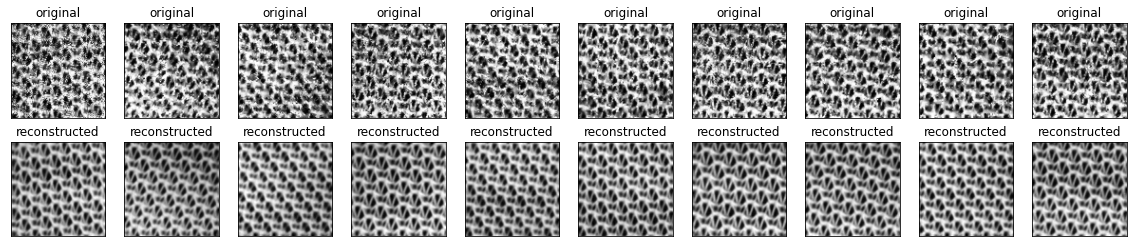

In [26]:
xs, ys = next(train_gen)
encoded_imgs = renet.encoder(xs).numpy()
decoded_imgs = renet.decoder(encoded_imgs).numpy()
show_imgs(xs, decoded_imgs)

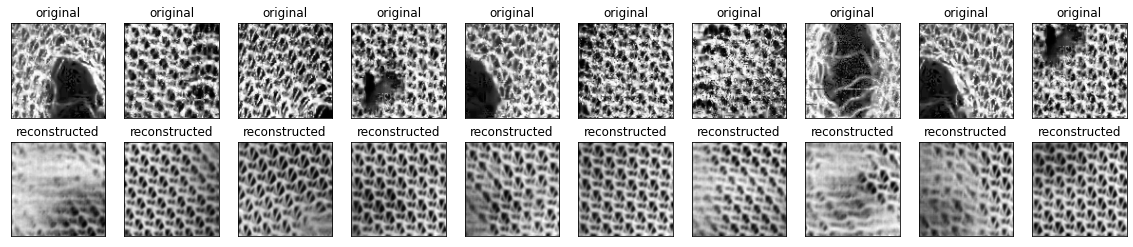

In [27]:
xs, ys = next(an_gen)
encoded_imgs = renet.encoder(xs).numpy()
decoded_imgs = renet.decoder(encoded_imgs).numpy()
show_imgs(xs, decoded_imgs)

In [28]:
def cal_mse_losses(model, gen, batch_size):
    losses = []
    num = gen.samples
    for i, (xs, ys) in enumerate(gen):
        if i > num//batch_size:
            break
        res = model.predict(xs)
        for r, x in zip(res, xs):
            losses.append((np.square(r - x)).mean())
    return losses

In [29]:
anomal_losses = cal_mse_losses(renet, an_gen, batch_size)
train_loss = cal_mse_losses(renet, train_gen, batch_size)
test_loss = cal_mse_losses(renet, test_gen, batch_size)
val_loss = cal_mse_losses(renet, val_gen, batch_size)

Text(0, 0.5, 'number of samples')

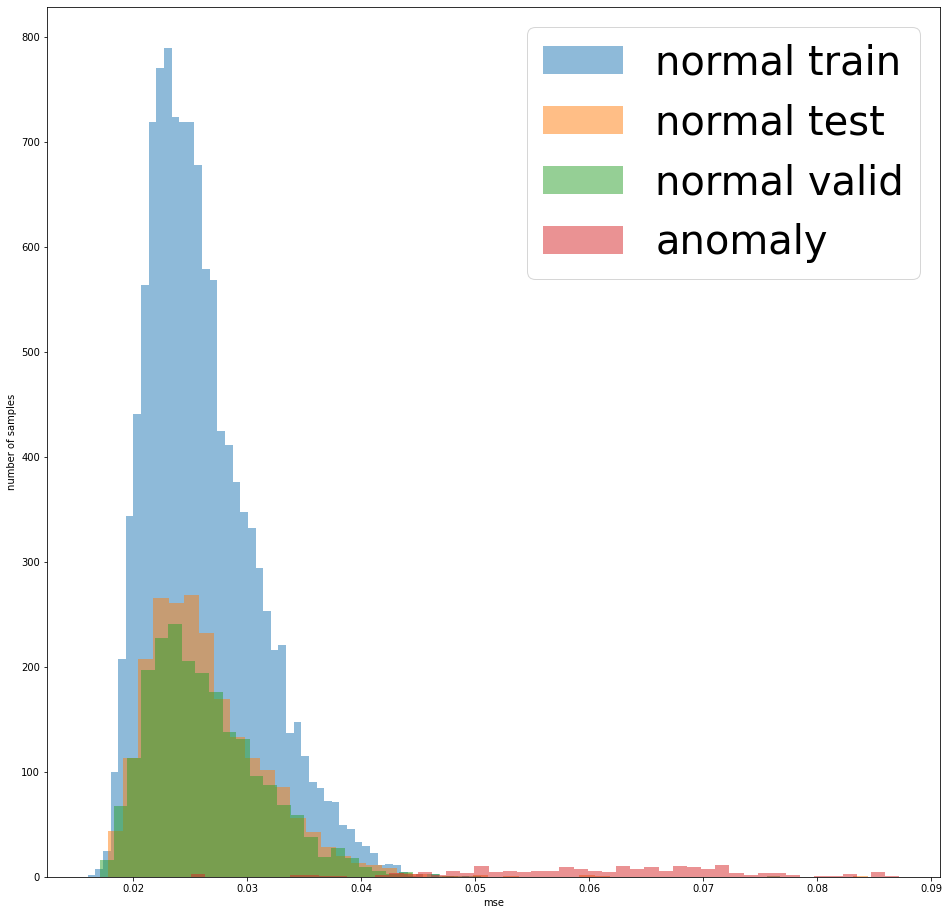

In [30]:
losses = [train_loss, test_loss, val_loss, anomal_losses]
titles = ['normal train', 'normal test', 'normal valid', 'anomaly']
plt.figure(figsize=(16, 16))
for i, (t, l) in enumerate(zip(titles, losses)):
    plt.hist(l, 50, histtype='bar', label=t, alpha=0.5)
    plt.legend(fontsize=40)
plt.xlabel('mse')
plt.ylabel('number of samples')

In [31]:
def cal_acc(losses, threshold, is_nomal):
    losses = np.array(losses)
    if is_nomal:
        return np.count_nonzero(losses <= threshold) / len(losses)
    else:
        return np.count_nonzero(losses >= threshold) / len(losses)

threshold = 0.0417
print(f'anomal data predict acc: {cal_acc(anomal_losses, threshold, is_nomal=False)}')
print(f'nomal train data predict acc: {cal_acc(train_loss, threshold, is_nomal=True)}')
print(f'nomal test data predict acc: {cal_acc(test_loss, threshold, is_nomal=True)}')
print(f'nomal val data predict acc: {cal_acc(val_loss, threshold, is_nomal=True)}')

anomal data predict acc: 0.9540816326530612
nomal train data predict acc: 0.996348195329087
nomal test data predict acc: 0.9894881170018281
nomal val data predict acc: 0.9920856610800745


In [32]:
def read_img(f):
    img = cv2.imread(f, 0)
    img = np.asarray(img)
    img = np.expand_dims(img,axis=-1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

anomal_img = read_img('./data1/anomal_data/anomal/4701.bmp')
nomal_img = read_img('./data1/nomal_data/nomal/155.bmp')

model = tf.keras.models.load_model('./model/renet')

re_nomal_img = model.predict(tf.stack([nomal_img]))
re_anomal_img = model.predict(tf.stack([anomal_img]))

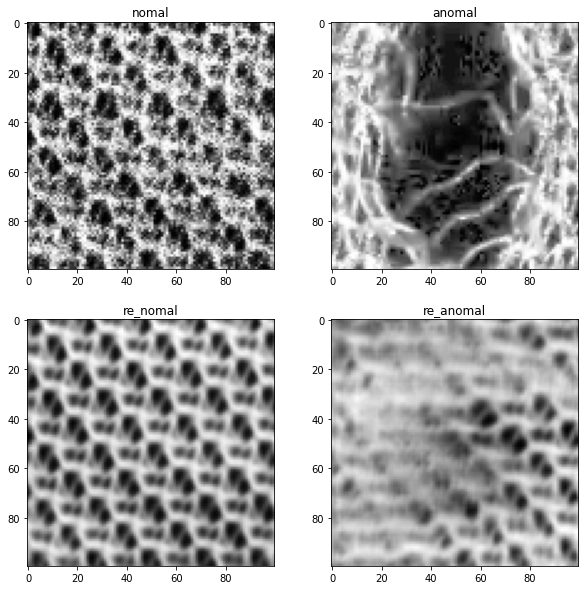

In [33]:
titles = ['nomal', 'anomal', 're_nomal', 're_anomal']
imgs = [nomal_img, anomal_img, re_nomal_img[0], re_anomal_img[0]]

plt.figure(figsize=(10, 10))
for i,(title, img) in enumerate(zip(titles, imgs)):
    plt.subplot(2,2, i +1)
    plt.imshow(img, cmap='gray')
    plt.title(title)

In [34]:
def predict(r, x):
    if np.square(r - x).mean() >= threshold:
        return 'anomal'
    else:
        return 'nomal'

print(f'nomal img, predict is : {predict(nomal_img, re_nomal_img)}')
print(f'anomal img, predict is : {predict(anomal_img, re_anomal_img)}')

nomal img, predict is : nomal
anomal img, predict is : anomal
